# imports

In [1]:
!pip install dython

In [2]:
import numpy as np
import pandas as pd
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception, ResNet50, EfficientNetV2L, VGG16
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow.keras as keras

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy

import zipfile
from dython.nominal import associations
from dython.nominal import identify_nominal_columns

import math
from sklearn import preprocessing
from skimage.transform import resize
from skimage import io
import albumentations as album

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report
from sklearn.utils import resample

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# classification  

In [4]:
pd.options.display.max_rows = 10

In [5]:
art_dir = '/kaggle/input/toy-art-data/toy_dataset/toy_dataset'
data_desrc_dir = '/kaggle/input/toy-art-data/balanced_labels_ru.csv'

In [6]:
labels_df = pd.read_csv(data_desrc_dir)

In [7]:
categorical_features=identify_nominal_columns(labels_df)
categorical_features

['FILE', 'AUTHOR', 'TECHNIQUE', 'FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'TUPLES']

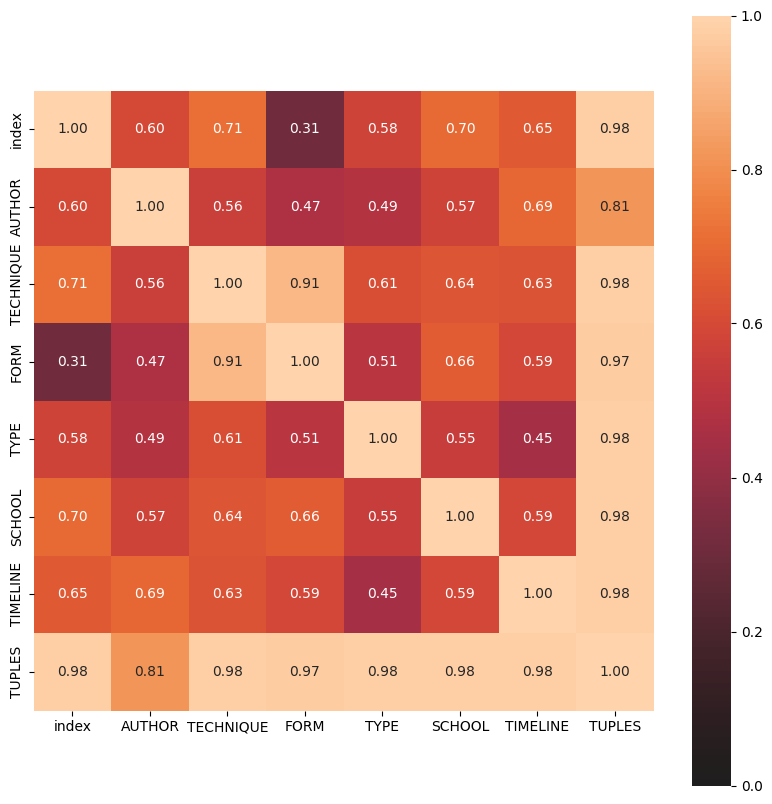

In [8]:
complete_correlation = associations(labels_df.drop(columns=['FILE', 'ID']), figsize=(10,10))

In [9]:
labels_df = labels_df.dropna()

In [10]:
labels_df['TUPLES'] = [(labels_df['TECHNIQUE'][i], labels_df['TYPE'][i],labels_df['SCHOOL'][i], labels_df['TIMELINE'][i]) for i in labels_df.index]

In [11]:
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels_df['TUPLES'])
np.savetxt("classes.txt", binarizer.classes_, fmt='%s')
binarizer.classes_

array(['-', 'Акварель', 'Акварель на бумаге', 'Бронза', 'Витраж',
       'Гобелен', 'Гравюра', 'Дерево', 'Дуб', 'Камень', 'Карандаш',
       'Красный мел', 'Ксилография', 'Липа', 'Литография', 'Манускрипт',
       'Масло и темпера на дереве', 'Масло и темпера на красном буке',
       'Масло и темпера на липе', 'Масло и темпера на панели',
       'Масло на бумаге', 'Масло на дереве', 'Масло на дубе',
       'Масло на дубовой панели', 'Масло на картоне', 'Масло на меди',
       'Масло на панели', 'Масло на тополиной панели', 'Масло на холсте',
       'Масло на холсте, переведённое с дерева', 'Медь', 'Мрамор',
       'Ореховое масло на штукатурке', 'Отдельная фреска', 'Офорт',
       'Панель', 'Пастель', 'Пастель на бумаге', 'Перо',
       'Перо и коричневые чернила', 'Перо и чернила',
       'Перо и чернила на бумаге', 'Позолоченная бронза',
       'Раскрашенное дерево', 'Рисунок', 'Серебро', 'Слоновая кость',
       'Стукко', 'Темпера и золото на дереве',
       'Темпера и золото на пан

In [12]:
y.shape

(31742, 114)

# some functions


In [13]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [15]:
def get_training_augmentation():
    train_transform = [
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

In [16]:
def plot_graphs(history, string, model_name):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['train_'+string, 'val_'+string])
  plt.savefig(model_name + string + '.png')
  np.savetxt("train_"+string+".csv", history.history[string], delimiter=",")
  np.savetxt("val_"+string+".csv", history.history['val_'+string], delimiter=",")
  plt.show()

# data loaders


In [33]:
class IconClassDataloader(keras.utils.PyDataset):
    def __init__(
            self,
            images_dir,
            image_data,
            y_encoded,
            shape = (256, 256, 3),
            batch_size = 16,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_data = image_data
        self.x = [os.path.join(images_dir, image_name) for image_name in image_data]
        self.y = y_encoded

        self.batch_size = batch_size
        self.shape = shape
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return int(math.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            batch_x = self.x[idx]
            batch_y = self.y[idx]
        else:
            low = int(idx * self.batch_size)
            high = int(min(low + self.batch_size, len(self.x)))
            batch_x = self.x[low:high]
            batch_y = self.y[low:high]
        x_return = []
        
        for file_name in batch_x:
            try:
                image=io.imread(file_name)
                if self.augmentation:
                    sample = self.augmentation(image=image)
                    image = sample['image']
                if self.preprocessing:
                    sample = self.preprocessing(image=image)
                    image = sample['image']
    
                x_return.append(image)
            
            except OSError:
                batch_y = np.delete(np.array(batch_y), batch_x.index(file_name), 0)

        return np.array([resize(x, self.shape) for x in x_return]), np.array(batch_y)

def get_validation_augmentation():
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256),
    ]
    return album.Compose(test_transform)

In [34]:
BATCH_SIZE = 64
IMAGE_SIZE = (299, 299, 3)

In [35]:
check_dataloader = IconClassDataloader(
    images_dir = art_dir,
    image_data = labels_df['FILE'].values,
    y_encoded = y,
    batch_size = 4,
    shape = IMAGE_SIZE,
    augmentation=get_training_augmentation()
)

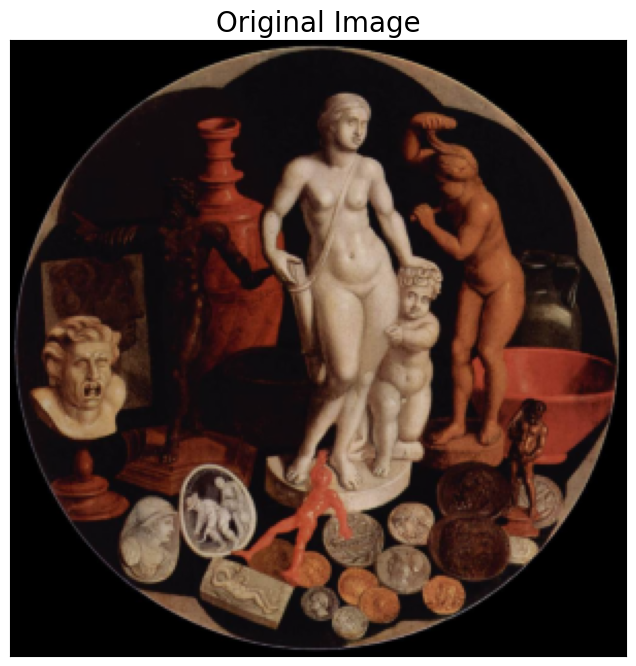

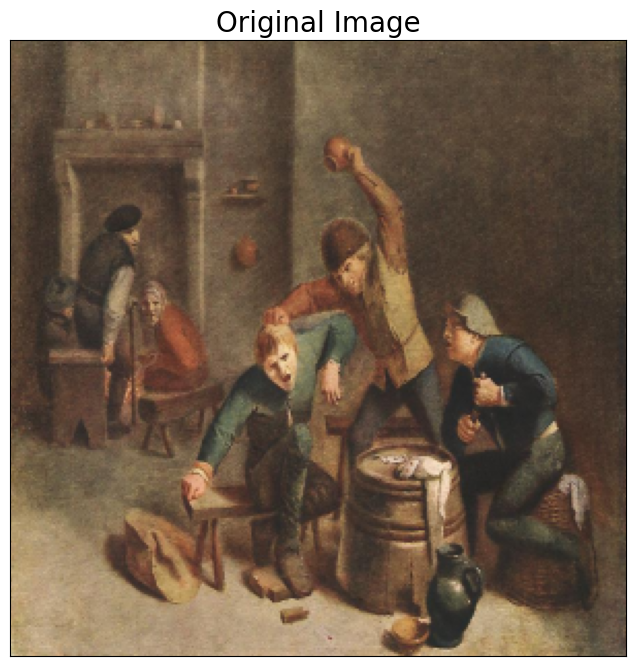

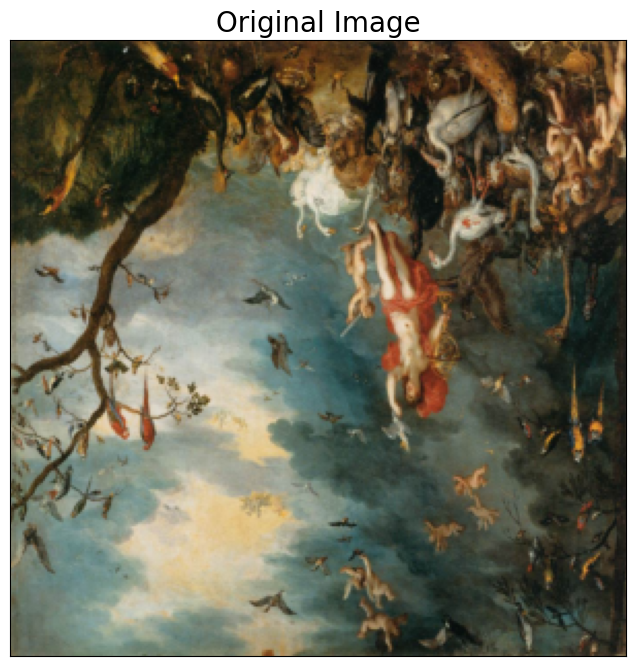

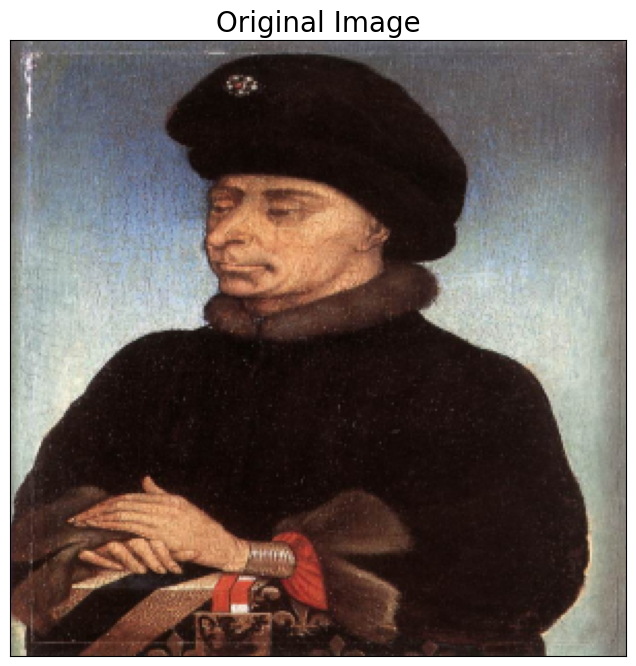

In [36]:
image, label = check_dataloader[random.randint(0, len(check_dataloader)-1)]
for j in range(len(image)):
    visualize(
        original_image = image[j],
    )

In [37]:
X_train, X_test, y_train, y_test = train_test_split(labels_df, labels_df['TUPLES'],
                               test_size=0.20,
                               random_state=42
                              )

In [38]:
training_dataloader = IconClassDataloader(
    images_dir = art_dir,
    image_data = X_train['FILE'].values,
    y_encoded = binarizer.transform(y_train),
    batch_size = BATCH_SIZE,
    shape = IMAGE_SIZE,
    augmentation=get_training_augmentation()
)
test_dataloader = IconClassDataloader(
    images_dir = art_dir,
    image_data = X_test['FILE'].values,
    y_encoded = binarizer.transform(y_test),
    batch_size = BATCH_SIZE,
    shape = IMAGE_SIZE,
    augmentation=get_validation_augmentation()
)

In [39]:
len(y_train), len(y_test)

(25393, 6349)

# models

In [24]:
def create_model(base_model, input_shape, output_shape, base_trainable = False):
    base_model.trainable = base_trainable
    model = keras.Sequential([
            keras.Input(shape=input_shape),
            base_model,
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(output_shape, activation='sigmoid')
            ])
    model.compile(optimizer='adamW',
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), 
                           tf.keras.metrics.Precision(), tf.keras.metrics.AUC()])
    return model

In [25]:
# model_arch = ResNet50(weights="imagenet", include_top=False, pooling="avg")
model_arch = EfficientNetV2L(weights="imagenet", include_top=False, pooling="avg")

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [26]:
pretrained_model_path = "/kaggle/input/models-to-classify-art/tensorflow2/default/5/model_en_v2.keras"
model_name = "model_en_v3.keras"

In [27]:
if pretrained_model_path:
    model = tf.keras.models.load_model(pretrained_model_path)
else:
    model = create_model(model_arch, IMAGE_SIZE, output_shape = y.shape[1], base_trainable = False)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 114)            │        29,298 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,206,584 (458.55 MB)

 Trainable params: 819,058 (3.12 MB)

 Non-trainable params: 117,749,408 (449.18 MB)

 Optimizer params: 1,638,118 (6.25 MB)

In [28]:
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 1, verbose = 1, restore_best_weights=True)

In [29]:
EPOCHS = 15

In [ ]:
history = model.fit(training_dataloader, epochs=EPOCHS,
                          validation_data=test_dataloader,
                          callbacks=[checkpoint,earlystopping]
                       )

In [ ]:
plot_graphs(history, "loss", model_name)

In [ ]:
plot_graphs(history, "precision", model_name)

In [ ]:
plot_graphs(history, "binary_accuracy", model_name)

In [ ]:
plot_graphs(history, "recall", model_name)

# inference

In [31]:
# model = tf.keras.models.load_model('/kaggle/working/'+model_name)
# model = tf.keras.models.load_model("/kaggle/input/models-to-classify-art/tensorflow2/default/5/model_en_v2.keras")

In [41]:
y_test = test_dataloader[:2000][1]
y_pred = model.predict(test_dataloader[:2000][0]).round()
y_test.shape, y_pred.shape

I0000 00:00:1746876625.079678     111 service.cc:145] XLA service 0x7c38703259b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746876625.079749     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746876625.079754     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746876647.500701     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 953ms/step


((2000, 114), (2000, 114))

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names = binarizer.classes_))

                                        precision    recall  f1-score   support

                                     -       0.98      0.40      0.57       112
                              Акварель       1.00      0.41      0.58        68
                    Акварель на бумаге       0.92      0.70      0.80        94
                                Бронза       0.94      0.97      0.95        65
                                Витраж       1.00      1.00      1.00         2
                               Гобелен       0.96      0.89      0.92        97
                               Гравюра       0.00      0.00      0.00        10
                                Дерево       0.99      0.88      0.93        82
                                   Дуб       0.00      0.00      0.00         5
                                Камень       0.00      0.00      0.00         5
                              Карандаш       0.00      0.00      0.00        13
                           Красный мел 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# image, label = test_dataloader[random.randint(0, len(test_dataloader)-1)]
# label = binarizer.inverse_transform(label)
# label_pred = model.predict(image).round()
# label_pred = binarizer.inverse_transform(label_pred)

# plt.figure(figsize = (20 , 20))

# for i in range(10):
#     plt.subplot(5 , 5, i+1)
#     plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
#     plt.imshow(image[i])
#     plt.title(f'Predicted: {label_pred}')
#     plt.axis("off")

In [ ]:
# print(label)

In [ ]:
# print(label_pred)